In [1]:
import sys

import pandas as pd
import time
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from nanoHUB.application import Application

application = Application.get_instance()
nanohub_db = application.new_db_engine('nanohub')
nanohub_metrics_db = application.new_db_engine('nanohub_metrics')
wang159_myrmekes_db = application.new_db_engine('wang159_myrmekes')

salesforce = application.new_salesforce_engine()
db_s = salesforce


``````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````
```````````````````````````````$$$$$``````````````````````````````````````````````````````````````````````````````````````````````````````````````````
`````````````````````````````$$$$`$$$$````````````````````````````````````````````````````````````````````````````````````````````````````````````````
`````````````````$$$$$```````$$`````$$$```````````````````````````````````````````````````````````````````````````````````````````````````````````````
````````````````$$```$$``````$$$$``$$$````````````````````````````````````````````````````````````````````````````````````````````````````````````````
````````````````$$$$$$$```````$$$$$$``````````````````````````````````````````````````````````````````````````````````````````````````````````````````
``````$$$$````````$$$$$```````$$$``````$$$$$$````````````````````````````````````````````````

2021-07-16 02:33:01,712| WARNING | Could not read SSH configuration file: ~/.ssh/config


2021-07-16 02:33:01,712 - [WARNING] sshtunnel.SSHTunnelForwarder [sshtunnel._read_ssh_config:1032]: Could not read SSH configuration file: ~/.ssh/config
2021-07-16 02:33:01,712 - [WARNING] sshtunnel.SSHTunnelForwarder [sshtunnel._read_ssh_config:1032]: Could not read SSH configuration file: ~/.ssh/config


2021-07-16 02:33:01,719| INFO    | 0 keys loaded from agent


2021-07-16 02:33:01,719 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_agent_keys:1060]: 0 keys loaded from agent
2021-07-16 02:33:01,719 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_agent_keys:1060]: 0 keys loaded from agent


2021-07-16 02:33:01,726| INFO    | 0 key(s) loaded


2021-07-16 02:33:01,726 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_keys:1117]: 0 key(s) loaded
2021-07-16 02:33:01,726 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_keys:1117]: 0 key(s) loaded


2021-07-16 02:33:01,734| INFO    | Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'


2021-07-16 02:33:01,734 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.__init__:978]: Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'
2021-07-16 02:33:01,734 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.__init__:978]: Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'
2021-07-16 02:33:01,741 - [INFO] nanoHUB.containers.dataaccess [connection.get_connection_for:78]: Started SSH Tunnel with db2.nanohub.org


2021-07-16 02:33:02,265| INFO    | Opening tunnel: 0.0.0.0:42171 <> 127.0.0.1:3306


2021-07-16 02:33:02,265 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel._serve_forever_wrapper:1433]: Opening tunnel: 0.0.0.0:42171 <> 127.0.0.1:3306
2021-07-16 02:33:02,265 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel._serve_forever_wrapper:1433]: Opening tunnel: 0.0.0.0:42171 <> 127.0.0.1:3306


2021-07-16 02:33:02,423| WARNING | Could not read SSH configuration file: ~/.ssh/config


2021-07-16 02:33:02,423 - [WARNING] sshtunnel.SSHTunnelForwarder [sshtunnel._read_ssh_config:1032]: Could not read SSH configuration file: ~/.ssh/config
2021-07-16 02:33:02,423 - [WARNING] sshtunnel.SSHTunnelForwarder [sshtunnel._read_ssh_config:1032]: Could not read SSH configuration file: ~/.ssh/config


2021-07-16 02:33:02,429| INFO    | 0 keys loaded from agent


2021-07-16 02:33:02,429 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_agent_keys:1060]: 0 keys loaded from agent
2021-07-16 02:33:02,429 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_agent_keys:1060]: 0 keys loaded from agent


2021-07-16 02:33:02,436| INFO    | 0 key(s) loaded


2021-07-16 02:33:02,436 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_keys:1117]: 0 key(s) loaded
2021-07-16 02:33:02,436 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_keys:1117]: 0 key(s) loaded


2021-07-16 02:33:02,442| INFO    | Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'


2021-07-16 02:33:02,442 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.__init__:978]: Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'
2021-07-16 02:33:02,442 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.__init__:978]: Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'
2021-07-16 02:33:02,448 - [INFO] nanoHUB.containers.dataaccess [connection.get_connection_for:78]: Started SSH Tunnel with db2.nanohub.org


2021-07-16 02:33:02,678| INFO    | Opening tunnel: 0.0.0.0:43653 <> 127.0.0.1:3306


2021-07-16 02:33:02,678 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel._serve_forever_wrapper:1433]: Opening tunnel: 0.0.0.0:43653 <> 127.0.0.1:3306
2021-07-16 02:33:02,678 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel._serve_forever_wrapper:1433]: Opening tunnel: 0.0.0.0:43653 <> 127.0.0.1:3306


2021-07-16 02:33:02,840| WARNING | Could not read SSH configuration file: ~/.ssh/config


2021-07-16 02:33:02,840 - [WARNING] sshtunnel.SSHTunnelForwarder [sshtunnel._read_ssh_config:1032]: Could not read SSH configuration file: ~/.ssh/config
2021-07-16 02:33:02,840 - [WARNING] sshtunnel.SSHTunnelForwarder [sshtunnel._read_ssh_config:1032]: Could not read SSH configuration file: ~/.ssh/config


2021-07-16 02:33:02,847| INFO    | 0 keys loaded from agent


2021-07-16 02:33:02,847 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_agent_keys:1060]: 0 keys loaded from agent
2021-07-16 02:33:02,847 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_agent_keys:1060]: 0 keys loaded from agent


2021-07-16 02:33:02,854| INFO    | 0 key(s) loaded


2021-07-16 02:33:02,854 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_keys:1117]: 0 key(s) loaded
2021-07-16 02:33:02,854 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.get_keys:1117]: 0 key(s) loaded


2021-07-16 02:33:02,861| INFO    | Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'


2021-07-16 02:33:02,861 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.__init__:978]: Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'
2021-07-16 02:33:02,861 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel.__init__:978]: Connecting to gateway: db2.nanohub.org:22 as user 'wang2506'
2021-07-16 02:33:02,868 - [INFO] nanoHUB.containers.dataaccess [connection.get_connection_for:78]: Started SSH Tunnel with db2.nanohub.org


2021-07-16 02:33:03,101| INFO    | Opening tunnel: 0.0.0.0:38063 <> 127.0.0.1:3306


2021-07-16 02:33:03,101 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel._serve_forever_wrapper:1433]: Opening tunnel: 0.0.0.0:38063 <> 127.0.0.1:3306
2021-07-16 02:33:03,101 - [INFO] sshtunnel.SSHTunnelForwarder [sshtunnel._serve_forever_wrapper:1433]: Opening tunnel: 0.0.0.0:38063 <> 127.0.0.1:3306
Obtained Salesforce access token ...... True


## Nanohub user growth

In [5]:
## need 
# 1) jos_users from nanohub with id,name,username,email,registerDate,lastvisitDate -> registered users
# 2) toolstart df filtered by username -> simulation users

# x-axis: each month from 2000 to current_year

# y-axis: 12 month trailing sum

# simulation users: unique users who have run at least 1 simulation

# registered users: new user registeration

# visitor count: unique IP address

In [6]:
## build jos_users_full
sql_query = "select id,name,username,email,registerDate,lastvisitDate from jos_users order by registerDate desc"
jos_users_full = pd.read_sql_query(sql_query, nanohub_db)
display(jos_users_full.head(2))
print(jos_users_full.shape)

,id,name,username,email,registerDate,lastvisitDate
0,332784,Toiyob Hossain,toiyob.eee.buet,toiyob.eee.buet@gmail.com,2021-07-16 02:19:26,2021-07-16 02:19:27
1,332783,Janeea Myles Dela Cruz,mylesdlcrz,janeeamyles.delacruz.pharma@ust.edu.ph,2021-07-16 02:19:23,2021-07-16 02:33:29


(253528, 6)


In [7]:
## build all users list
sql_query = "select datetime,ip,countryip,user,tool from toolstart where user != 'instanton' "\
+"and user != 'gridstat' and datetime <= '2002-01-01' and datetime >= '0000-01-01' order by datetime desc"
toolstart_df = pd.read_sql_query(sql_query, nanohub_metrics_db)
display(toolstart_df.head(2))
print(toolstart_df.shape)

,datetime,ip,countryip,user,tool
0,2001-12-31 23:23:51,68.32.42.69,US,jjeon,Adeptf
1,2001-12-31 23:23:23,68.32.42.69,US,jjeon,Adeptf


(138857, 5)


In [8]:
## convert the dataframes to datetime
jos_users_full['registerDate'] = pd.to_datetime(jos_users_full.registerDate)
jos_users_full['lastvisitDate'] = pd.to_datetime(jos_users_full.lastvisitDate)

toolstart_df['datetime'] = pd.to_datetime(toolstart_df.datetime)

In [9]:
import datetime
today = datetime.datetime.now()
print(today)

2021-07-16 02:35:04.120009


In [10]:
all_months_list = list()
for this_year in range(2000,today.year+2):
    for this_month in range(1,12+1):
        all_months_list.append(datetime.datetime(this_year, this_month, 1))
        
for this_year in range(today.year,today.year+2):
    for this_month in range(1,today.month+1):
        all_months_list.append(datetime.datetime(this_year, this_month, 1))
        
months_bin = pd.DataFrame(all_months_list, columns=['year_month'])

# display
months_bin.head(2)

,year_month
0,2000-01-01
1,2000-02-01


In [11]:
## jos_users_full registration cumulative monthly
months_bin['registered_12_trail'] = months_bin.year_month.apply(lambda x:  \
                                jos_users_full.username[(jos_users_full.registerDate < x)\
                            &(jos_users_full.registerDate > (x-datetime.timedelta(days=365)))].nunique() )

In [12]:
##the all users must be done in a bi-yearly basis
months_bin['sim_12_trail'] = months_bin.year_month.apply(lambda x: toolstart_df.user[(toolstart_df.datetime < x) \
                                        &(toolstart_df.datetime > (x-datetime.timedelta(days=365)))].nunique() )

In [13]:
print(months_bin['year_month'].to_list().index(pd.to_datetime('2002-01-01')) )
temp = months_bin['sim_12_trail']#[:25]

24


In [14]:
## check if cached data is available locally
import os
cwd = os.getcwd()

In [35]:
try:
    months_bin2 = pd.read_csv(cwd+'/cached_data/nh_user_growth.csv')
    months_bin2['year_month'] = pd.to_datetime(months_bin2['year_month'],format='%Y-%m-%d')
    data_flag = True
except:
    data_flag = False
print(data_flag)

True


In [36]:
from copy import deepcopy

In [37]:
if data_flag == False: # need to gather all data
    start_year = 2002 # 2000 and 2001 done above 
else:
    ts12 = months_bin2['sim_12_trail'].to_list()
    ## find all consecutive 0s in sim_12_trail
    con0s = [] # indexes of the start of the consecutive zeros
    for t_ind,t_val in enumerate(ts12):
        con_flag = False
        if t_ind > 0:
            con_flag = (ts12[t_ind-1]==0) and (t_val==0)
        if con_flag == True:
            con0s.append(t_ind-1)
#     con0s[1] # this should be the new start year
#     start_year = months_bin2['year_month'].to_list()[-1].year
    start_year = months_bin2['year_month'].to_list()[con0s[1]].year-1
    months_bin3 = months_bin.iloc[months_bin['year_month'].to_list().index(months_bin2['year_month'].to_list()[-1])+1:,:]
    months_bin4 = pd.concat([months_bin2,months_bin3])
    months_bin = deepcopy(months_bin4)
    
    # join months_bin and months_bin2
#     months_bin2['year_month'] = deepcopy(months_bin['year_month'])
#     months_bin = deepcopy(months_bin2)

In [38]:
months_bin = months_bin.drop(columns=['Unnamed: 0'])
display(months_bin.head(2))
display(months_bin.tail(2))

,year_month,registered_12_trail,sim_12_trail
0,2000-01-01,15,0
1,2000-02-01,19,0


,year_month,registered_12_trail,sim_12_trail
288,2022-06-01,3068,0
289,2022-07-01,1194,0


In [93]:
while start_year < today.year+1:
    prev_temp_ind = months_bin['year_month'].to_list().index(pd.to_datetime(str(start_year)+'-01-01')) 

    start_year += 1
    end_date = r"'"+str(start_year)+r"-01-01'"
    start_date = r"'"+str(start_year-2)+r"-01-01'"

    sql_query = "select datetime,ip,countryip,user,tool from toolstart where user != 'instanton' "\
        +"and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date+" order by datetime desc"
    toolstart_df = pd.read_sql_query(sql_query, nanohub_metrics_db)
    toolstart_df['datetime'] = pd.to_datetime(toolstart_df.datetime)
    print(toolstart_df.shape)

    temp2 = months_bin.year_month.apply(lambda x: toolstart_df.user[(toolstart_df.datetime < x) \
                                        &(toolstart_df.datetime > (x-datetime.timedelta(days=365)))].nunique() )

    max_temp_ind = months_bin['year_month'].to_list().index(pd.to_datetime(str(start_year)+'-01-01')) 

    temp[prev_temp_ind:max_temp_ind] = temp2[prev_temp_ind:max_temp_ind] #updates months_bin as pointer effect

(122148, 5)
(136210, 5)
(147533, 5)
(114575, 5)
(195951, 5)
(389282, 5)
(631227, 5)
(755597, 5)
(757271, 5)
(786048, 5)
(812523, 5)
(914351, 5)
(1326836, 5)
(1573469, 5)
(1594198, 5)
(2022821, 5)
(1932538, 5)
(1353033, 5)
(1642209, 5)
(1623116, 5)


In [94]:
months_bin['sim_12_trail'] = deepcopy(temp)

In [99]:
months_bin.iloc[:-55,:]

,year_month,registered_12_trail,sim_12_trail
0,2000-01-01,15,0
1,2000-02-01,19,0
2,2000-03-01,24,133
3,2000-04-01,26,199
4,2000-05-01,30,244
...,...,...,...
254,2021-03-01,31523,23490
255,2021-04-01,31906,23779
256,2021-05-01,31622,23399
257,2021-06-01,31799,23090


In [79]:
# months_bin['year_month'].to_list()[-32:] #12 + today.month

In [102]:
if data_flag == True: 
    months_bin2 = months_bin.iloc[:months_bin.shape[0]-(2*24+today.month),:]

In [103]:
display(months_bin2.tail(20))

,year_month,registered_12_trail,sim_12_trail
239,2019-12-01,25623,17268
240,2020-01-01,25100,16603
241,2020-02-01,25025,16865
242,2020-03-01,24502,16812
243,2020-04-01,24623,17221
244,2020-05-01,25457,17777
245,2020-06-01,26249,18112
246,2020-07-01,27715,18808
247,2020-08-01,27598,18884
248,2020-09-01,27728,19540


In [120]:
# calculating total number of visitors
import json
with open(cwd+'/visitors.json') as f: # obtain visitors.json from https://nanohub.org/usage and viewing page source at lines 273-278
    visitor_dict = f.read()
    visitor_dict = visitor_dict.replace("\'",'\"')
    visitor_dict = json.loads(visitor_dict)

In [121]:
import re
pattern = re.compile('\d+]')
step1 = re.findall(pattern,visitor_dict['data'])
res_visitors = [i[:-1] for i in step1]

In [122]:
import numpy as np
res_visitors2 = list(np.zeros(12*6+14)) + res_visitors

In [123]:
print(len(res_visitors2))
print(res_visitors2[-5:])

268
['1872976', '1947336', '1923533', '2040179', '2059461']


In [115]:
months_bin2

,year_month,registered_12_trail,sim_12_trail
0,2000-01-01,15,0
1,2000-02-01,19,0
2,2000-03-01,24,133
3,2000-04-01,26,199
4,2000-05-01,30,244
...,...,...,...
254,2021-03-01,31523,23490
255,2021-04-01,31906,23779
256,2021-05-01,31622,23399
257,2021-06-01,31799,23090


In [126]:
while months_bin2.shape[0] < len(res_visitors2):
    res_visitors2 = res_visitors2[1:]
# display(months_bin.iloc[-20:-10,:])

In [128]:
months_bin2['visitors_12_trail'] = res_visitors2

In [132]:
months_bin = deepcopy(months_bin2)

In [139]:
months_bin.shape

(259, 4)

In [133]:
months_bin.to_csv(cwd+'/cached_data/nh_user_growth.csv')
print('latest data cached')

latest data cached


In [137]:
months_bin

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
0,2000-01-01,15,0,0.0
1,2000-02-01,19,0,0.0
2,2000-03-01,24,133,0.0
3,2000-04-01,26,199,0.0
4,2000-05-01,30,244,0.0
...,...,...,...,...
254,2021-03-01,31523,23490,1872976
255,2021-04-01,31906,23779,1947336
256,2021-05-01,31622,23399,1923533
257,2021-06-01,31799,23090,2040179


In [185]:
with open(cwd+'/dev_flags.txt','r') as f:
    raw_flags = f.read()

In [188]:
flag_pattern = re.compile(r'= \w+')
flags1 = re.findall(flag_pattern,raw_flags)

In [190]:
flags_result = [i[2:] for i in flags1]

In [192]:
dev_flag = flags_result[0]
prod_flag = flags_result[1]

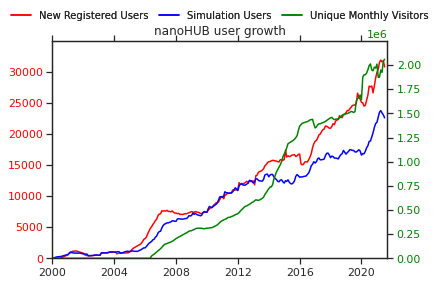

In [198]:
from matplotlib import pyplot as plt
import seaborn as sns
import os
sns.set()
sns.set_style("white")
#plt.figure(figsize=(9,6))
fig, ax1 = plt.subplots()
ax1.clear()
ax1.plot(months_bin.year_month[:], months_bin.registered_12_trail[:], color='red', label='New Registered Users');
ax1.plot(months_bin.year_month[:], months_bin.sim_12_trail[:], color='blue', label='Simulation Users');
#plt.plot(months_bin.year_month,res_visitors2)

ax1.set_title('nanoHUB user growth');

ax1.set_xlim([datetime.datetime(2000,1,1), datetime.datetime(2021,9,1)]);
ax1.set_ylim([0, 35000])
ax1.set_yticks(np.arange(0,35000,5000))
ax1.tick_params(axis='y',labelcolor='red')
# ax1.set_ylabel('Unique Users/Month')

ax2 = ax1.twinx()
# ax2.set_ylabel('Unique Visitors/Month')
ax2.plot(months_bin.year_month[:],months_bin.visitors_12_trail[:],color='green',label='Unique Monthly Visitors')
ax2.tick_params(axis='y',labelcolor='green')
ax2.set_yticks(np.arange(0,2000000+250000,250000))
ax2.set_ylim([0,2000000+250000])
# ax2.legend(loc='center left')
# plt.ylabel('Annualized nanoHUB Visitors');
# ax1.legend(loc='upper left');
# ax1.legend()
# ax2.legend()

h,l = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
kw = dict(ncol=3,loc = 'lower center',frameon=False)
#(x, y, width, height)
h += h2
l += l2
leg1 = ax1.legend(h,l,bbox_to_anchor=(-0.15,1.05,1.3,0.2),\
                mode='expand',fontsize=10,**kw)
ax1.add_artist(leg1)

cwd = os.getcwd()
if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/users_registrered_visitors_12_months.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/users_registrered_visitors_12_months.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/users_registrered_visitors_12_months.png', dpi=1000, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/users_registrered_visitors_12_months.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/users_registrered_visitors_12_months.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/users_registrered_visitors_12_months.png', dpi=1000, bbox_inches='tight')
else:
    print('no printing flag is active')